In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns

from tqdm import tqdm
import gymnasium as gym
from collections import deque
from gym.wrappers import RecordEpisodeStatistics

Load the environment

In [3]:
env = gym.make('Blackjack-v1', sab=True, render_mode="rgb_array")

Observing the environment

In [4]:
#reset environment to get first observation
done = False
observation, info = env.reset()
print(observation) 
print(info)

# Observation is a tuple of 3 values:
# 1. The players current sum
# 2. Values of the dealers face-up card
# 3. Boolean wheter the player holds a usable ace

(20, 4, 0)
{}


Executing an action

In [5]:
action = env.action_space.sample() #sample random action from all valid actions
observation, reward, terminated, truncated, info = env.step(action) #execute the actions

Implement Epsilon-greedy strategy

In [6]:
class BlackjackAgent:
    def __init__(self, learning_rate:float, initial_epsilon:float, epsilon_decay:float, final_epsilon:float, discount_factor:float = 0.95):
        #Initialize a RL agent with empty dictionary of state-action value (q_values), a learning rate and an epsilon
        self.q_values = defaultdict(lambda:np.zeros(env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs:tuple[int, int, bool]) -> int:

        #Return the best action with probability (1-epsilon) otherwise a random action with probability epsilon to ensure exploration
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        
        else:
            return int(np.argmax(self.q_values[obs]))
        
    def update(
        self, 
        obs:tuple[int,int,bool],
        action:int,
        reward:float,
        terminated:bool,
        next_obs:tuple[int,int,bool]
    ):
        
        #Updates the Q-value of an action
        future_q_value = (not terminated)*np.max(self.q_values[next_obs])
        temporal_difference = (reward + self.discount_factor * future_q_value - self.q_values[obs][action])
        
        self.q_values[obs][action]=(
            self.q_values[obs][action] + self.lr*temporal_difference
        )

        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
        



Training the agent

In [7]:
learning_rate = 0.01
n_episodes = 500
start_epsilon = 1
epsilon_decay = start_epsilon/(n_episodes/2) #reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon
)

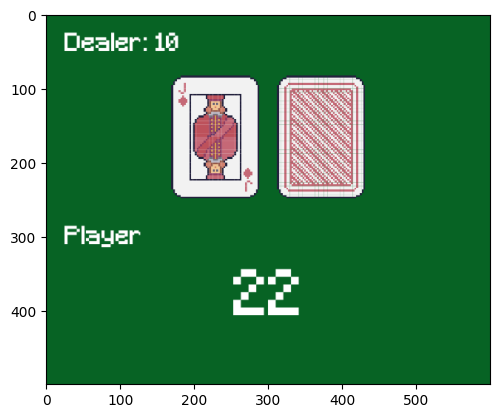

100%|██████████| 500/500 [00:59<00:00,  8.36it/s]


In [8]:
from IPython.display import clear_output
env = gym.make('Blackjack-v1', sab=True, render_mode="rgb_array")
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm (range(n_episodes)):
    obs, info = env.reset()
    done = False 
    clear_output()

    #play one episode:
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(obs, action, reward, terminated, next_obs)
        frame = env.render()
        plt.imshow(frame)
        plt.show()

        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

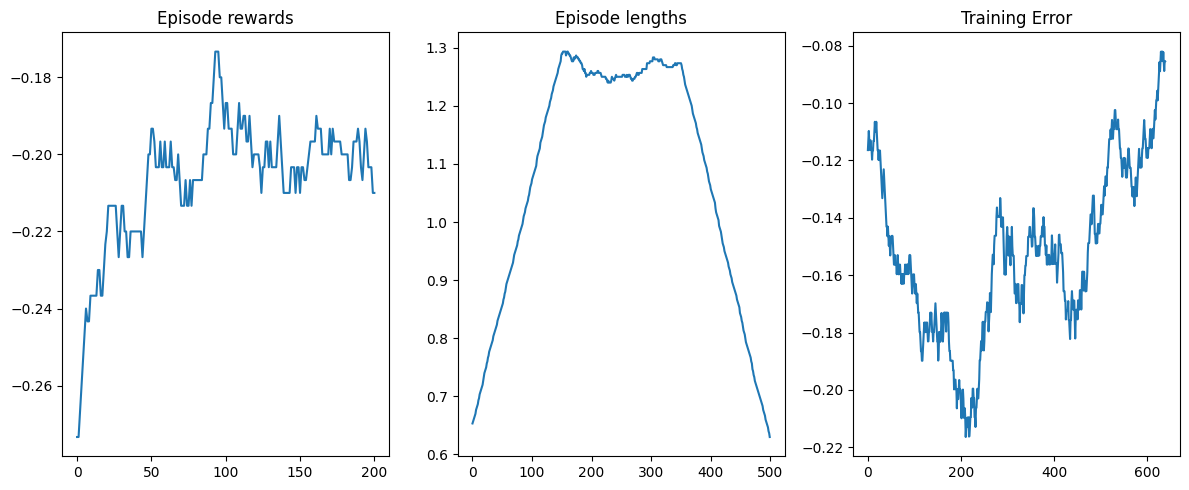

In [10]:
rolling_length = 300
fig, axs = plt.subplots(ncols=3, figsize=(12,5))
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )/rolling_length
)

axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode = "same"
    )/rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()